In [301]:
import pandas as pd
import numpy as np
import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn import preprocessing
import scipy
from impala.dbapi import connect
from impala.util import as_pandas
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import scipy.stats.stats as stats
rcParams['figure.figsize'] = 12, 4
target = 'labels'
#change add some score
predictors = ['phone_gray_score','honeypot_model_score','contacts_relatives_redline_cnt','contacts_loankeywords_redline_cnt','tongdun_union_score','n_91applytimes_cnt','n_91rejectprecent','ant_score','tc_loankeywords_callcnt_last1m','tc_collection_callcnt_last3m','tc_relatives_callcnt_lasthalfyear']

获取数据

In [107]:
def get_data(sql):
    conn = connect(host = '10.1.169.3',port = 10000, auth_mechanism = 'PLAIN')
    cursor = conn.cursor()
    cursor.execute(sql)
    df = as_pandas(cursor)
    return df
def get_df_time(df,start,end):
    df_copy = df.copy()
    df_copy = df_copy[(df_copy.dt >=start) & (df_copy.dt <end)]
    return df_copy
def get_and_fix_train(df,start,end):
    train = get_df_time(df,start,end)
    train.fillna(-999.0,inplace=True)
    train[predictors] = train[predictors].apply(pd.to_numeric,errors='ignore')
    return train

In [72]:
%store -r df_all_train
%store -r df_ar_train
%store -r df_ar_score_before
%store -r df_ar_score_now

In [321]:
df_ar_train_07 = get_data('select * from tmp.cebai_armodel_20170525_20170720_labels')
df_ar_score_07 = get_data('select * from tmp.cebai_armodel_20170525_20170720')

In [322]:
print(len(df_ar_train_07))
print(len(df_ar_score_07))

130281
703619


In [196]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns

In [325]:
train = get_and_fix_train(df_ar_train_07,'2017-05-25','2017-06-05')

In [329]:
print(len(train))

90865


In [317]:
# define a binning function
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)
def mono_bin(Y, X, n = 10):
  # fill missings with -999
  X2 = X.fillna(-999)
  r = 0
  while np.abs(r) < 1:
    d1 = pd.DataFrame({"X": X2, "Y": Y, "Bucket":pct_rank_qcut(X2, 10)})
    d2 = d1.groupby('Bucket', as_index = True)
    r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
    n = n - 1
  d3 = pd.DataFrame(d2.min().X, columns = ['min_' + X.name])
  d3['max_' + X.name] = d2.max().X
  d3[Y.name] = d2.sum().Y
  d3['total'] = d2.count().Y
  d3[Y.name + '_rate'] = d2.mean().Y
  d4 = (d3.sort_index(by = 'min_' + X.name)).reset_index(drop = True)
  return d4

In [244]:
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plot
import numpy as np
from math import sqrt,fabs,exp
alg_rf = ensemble.RandomForestClassifier(n_estimators = 2000,
                            max_depth = 7,
                            oob_score = True,
                            random_state = 531,
                            class_weight = 'auto')
def rf_train(alg,rf_param,dtrain,predictors,target):
    X = dtrain[predictors]
    y = dtrain[target]
    xTrain,xTest,yTrain,yTest = train_test_split(X.values,y.values.ravel(),test_size = 0.2,random_state = 520)
    alg.fit(xTrain,yTrain)
    print("online----------oob_score:%f" % alg.oob_score_)
    prediction = alg.predict_proba(xTest)
    auc = roc_auc_score(yTest,prediction[:,1:2])
    print ("online-------AUC Score (test):%f" % auc)
    return alg
def grid_search(alg,rf_param,dtrain,predictors,target):
    X = dtrain[predictors]
    y = dtrain[target]
    X,y  = X.values,y.values.ravel()
    param_test1 = {'n_estimators':np.linspace(10,200,50,dtype = int),'max_depth':np.linspace(1,11,9,dtype = int)}
    gsearch1 = GridSearchCV(estimator = alg , 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
    gsearch1.fit(X,y)
    print(gsearch1.grid_scores_)
    print('***********************')
    print(gsearch1.best_params_)
    print('***********************')
    print(gsearch1.best_score_)

In [175]:
rf = rf_train(alg_rf,rf_param,train,predictors,target)

online----------oob_score:0.609159
online-------AUC Score (test):0.615985


模型训练-----XGB

In [245]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    X = dtrain[predictors]
    y = dtrain[target]
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval= False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(X, y,eval_metric='auc')
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1] 
    print('the best n_estimators is %d ' % alg.get_xgb_params()['n_estimators'])
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))             
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg

In [266]:
fixed_parameters = {'learning_rate':0.1,
            'n_estimators':63,
            'max_depth':5,
            'min_child_weight':1,
            'gamma':0.2,
            'subsample':0.8,
            'colsample_bytree':0.9,
            'objective':'binary:logistic',
            'nthread' :1,
            'scale_pos_weight':1,
            'seed':27}
def train_xgb(train):
    xgb1 = xgb.XGBClassifier(
        learning_rate =0.01,
        n_estimators=3000,
        max_depth=5,
        min_child_weight=1,
        gamma=0.2,
        subsample=0.8,
        colsample_bytree=0.9,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27  ,
        reg_alpha = 0.005)
    xgb_out = modelfit(xgb1, train, predictors)
    return xgb_out

the best n_estimators is 1188 

Model Report
Accuracy : 0.9214
AUC Score (Train): 0.661736


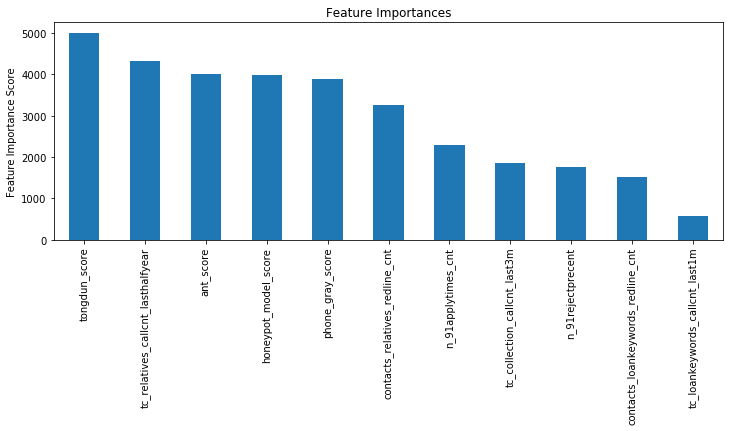

In [130]:
est = train_xgb(train)

In [201]:
import pickle
xgb_pk = pickle.dump(est, open("cb_xgb_0205.pkl", 'wb'))
#est.save_model('cb_xgb_0205.model')

the best n_estimators is 921 

Model Report
Accuracy : 0.8623
AUC Score (Train): 0.698354


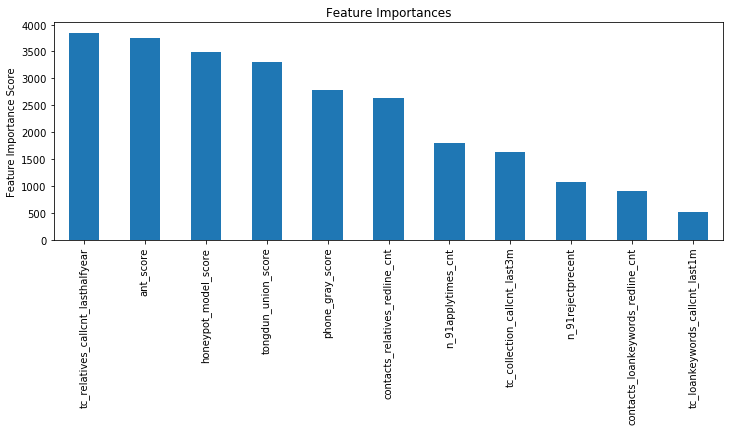

In [326]:
est1 = train_xgb(train)

In [249]:
def Tune_max_depth_and_min_child_weight(dtrain):
    param_test1 = { 'max_depth':np.arange(3,10,2,dtype = int ), 'min_child_weight':np.arange(1,6,2,dtype = int )}
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( fixed_parameters), param_grid = param_test1, scoring='roc_auc',n_jobs= 1, cv=5)
    gsearch1.fit(dtrain[predictors],dtrain[target])
    print(gsearch1.cv_results_)
    print('***********************')
    print(gsearch1.best_params_)
    print('***********************')
    print(gsearch1.best_score_)

In [250]:
Tune_max_depth_and_min_child_weight(train)

{'mean_test_score': array([ 0.64741747,  0.64811829,  0.64801035,  0.64855084,  0.64733038,
        0.64851448,  0.64345776,  0.64308442,  0.64267813,  0.63640485,
        0.63504701,  0.63456288]), 'std_score_time': array([ 0.00047701,  0.00067098,  0.00051623,  0.01696854,  0.00056648,
        0.00110923,  0.00083633,  0.00089625,  0.00182209,  0.00101835,
        0.00043826,  0.00310026]), 'mean_score_time': array([ 0.02990417,  0.02983871,  0.03025126,  0.05575514,  0.0421834 ,
        0.04205723,  0.05159979,  0.05214486,  0.05273695,  0.06419954,
        0.0639535 ,  0.06691232]), 'std_train_score': array([ 0.00114995,  0.00116457,  0.00113966,  0.00264488,  0.00229   ,
        0.00181151,  0.00143955,  0.0036791 ,  0.00290077,  0.00380343,
        0.00339016,  0.00482053]), 'mean_train_score': array([ 0.66642248,  0.66662985,  0.66641519,  0.70463293,  0.70339114,
        0.70212045,  0.7741877 ,  0.76641676,  0.76201638,  0.86723738,
        0.85015953,  0.83873357]), 'std_test

In [258]:
def Tune_gamma(train):
    param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}
    gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1,
        n_estimators=63,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.9,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27 ), 
 param_grid = param_test3, scoring='roc_auc',n_jobs= 1,iid=False, cv=5)
    gsearch3.fit(train[predictors],train[target])
    print(gsearch3.cv_results_)
    print('***********************')
    print(gsearch3.best_params_)
    print('***********************')
    print(gsearch3.best_score_)

In [259]:
Tune_gamma(train)

{'mean_test_score': array([ 0.64946479,  0.64931827,  0.64960185,  0.64929858,  0.64922699]), 'rank_test_score': array([2, 3, 1, 4, 5], dtype=int32), 'mean_score_time': array([ 0.0310792 ,  0.03220563,  0.03095517,  0.03099933,  0.03179173]), 'param_gamma': masked_array(data = [0.0 0.1 0.2 0.3 0.4],
             mask = [False False False False False],
       fill_value = ?)
, 'std_score_time': array([ 0.00039362,  0.00088325,  0.00051983,  0.00074088,  0.00187471]), 'split3_test_score': array([ 0.65394596,  0.65301065,  0.65319731,  0.65384497,  0.65384418]), 'split2_train_score': array([ 0.69333819,  0.69333835,  0.69322229,  0.6930754 ,  0.69326351]), 'split2_test_score': array([ 0.64200864,  0.64201344,  0.64197457,  0.64079462,  0.64100968]), 'params': ({'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}), 'mean_train_score': array([ 0.6916752 ,  0.69155685,  0.69165447,  0.69137949,  0.69185716]), 'std_fit_time': array([ 0.00945866,  0.01451177,  0.01001

In [264]:
def Tune_subsample_and_colsample_bytree(train):
    param_test4 = { 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]}
    gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( fixed_parameters), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch4.fit(train[predictors],train[target])
    print(gsearch4.cv_results_)
    print('***********************')
    print(gsearch4.best_params_)
    print('***********************')
    print(gsearch4.best_score_)

In [265]:
Tune_subsample_and_colsample_bytree(train)

KeyboardInterrupt: 

In [49]:
def Tuning_Regularization_Parameters(train):
    param_test6 = { 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
    gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( fixed_parameters ), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch6.fit(train[predictors],train[target])
    print(gsearch6.cv_results_)
    print('***********************')
    print(gsearch6.best_params_)
    print('***********************')
    print(gsearch6.best_score_)

In [237]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
def logloss(attempt,actual,epsilon=1.0e-15):
    attempt = np.clip(attempt,epsilon,1.0-epsilon)
    return -np.mean(actual*np.log(attempt)+(1.0-actual)*np.log(1.0-attempt))
def blend(clfs,X,y,X_submission):
    np.random.seed(0)
    n_folds = 10
    verbose = True
    shuffle = False
    #xi pai
    if shuffle:
        idx = np.random.permutation(y.size)
        X = X[idx]
        y = y[idx]
    skf = list(StratifiedKFold(y,n_folds))
    print("Creating train and test sets for blending")
    dataset_blend_train = np.zeros((X.shape[0],len(clfs)))
    dataset_blend_test = np.zeros((X_submission.shape[0],len(clfs)))
    for j,clf in enumerate(clfs):
        dataset_blend_test_j = np.zeros((X_submission.shape[0],len(skf)))
        for i,(train,test) in enumerate(skf):
            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]
            clf.fit(X_train,y_train)
            y_submission = clf.predict_proba(X_test)[:,1]
            dataset_blend_train[test,j] = y_submission
            dataset_blend_test_j[:,i] = clf.predict_proba(X_submission)[:,1]
        dataset_blend_test[:,j] = dataset_blend_test_j.mean(1)
    clf = LogisticRegression()
    clf.fit(dataset_blend_train,y)
    y_submission = clf.predict_proba(dataset_blend_test)[:,1]
    #Linear stretch of predictions to [0,1]
    y_submission = (y_submission - y_submission.min()) / (y_submission.max() - y_submission.min())
    #SAVING 
    return y_submission
def model_combine_pred(train_X,train_y,test_x):
    clfs = [RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini'),
            RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='entropy'),
            ExtraTreesClassifier(n_estimators=200, n_jobs=-1, criterion='gini'),
            ExtraTreesClassifier(n_estimators=200, n_jobs=-1, criterion='entropy'),
            GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=200)]
    pred = blend(clfs,train_X,train_y,test_x)
    return pred

In [238]:
def Eva_KS(model,df,start,end):
    test = get_and_fix_train(df,start,end)
    dtest = xgb.DMatrix(test[predictors], test[target]) 
    eval_pre = pd.Series(model.predict(dtest), index=test.index)
    print ('Evaluation KS: '), scipy.stats.ks_2samp(eval_pre[test[target]==1], eval_pre[test[target]==0])

In [274]:
import numpy as np
import pandas as pd
from collections import Counter
def ks_value(pred,true,n):
    score = (1.-pred)*1000
    index = score.argsort()
    score_sort = np.sort(score)
    true_sort = true[index]
    len_num = pred.size
    add = int(len_num/n)
    out = []
    for i in get_split_len(len_num,n):
        if i == get_split_len(len_num,n)[-1]:
            good_num,bad_num,total = get_good_bad(true_sort,i,-1)
            min_value,max_value = get_max_min(score_sort,i,-1)
            temp = [min_value,max_value,total,bad_num,good_num]
        else:
            good_num,bad_num,total = get_good_bad(true_sort,i,i+add)
            min_value,max_value = get_max_min(score_sort,i,i+add)
            temp = [min_value,max_value,total,bad_num,good_num]
        out.append(temp)
    return out
def list_to_dataframe(out):
    df = pd.DataFrame.from_records(out,columns = ["min_value","max_value","total","bad_num","good_num"])
    return df
def get_good_bad(true,startindex,endindex):
    if endindex == -1:
        true_index = true[startindex:]
    else:
        true_index = true[startindex:endindex]
    c = Counter([i for i in true_index])
    total = true_index.size
    return c[0],c[1],total
def get_max_min(pred,startindex,endindex):
    return pred[startindex],pred[endindex]
def get_split_len(len_num,n):
    out = [0]
    add = int(len_num/n)
    index = 0
    for i in range(n-1):
        index += add
        out.append(int(index))
    return out
def get_start_end(pred,cuts):
    out1 = cuts_off_array(pred,cuts)
    out2 = get_cuts_num(out1)
    out = [0]
    index = 0
    for i in out2:
        index += i
        out.append(int(index))
    return out
def ks_value_cuts(pred,true,cuts):
    score = (1.-pred)*1000
    index = score.argsort()
    score_sort = np.sort(score)
    true_sort = true[index]
    out = []
    start_end = get_start_end(score_sort,cuts)
    for i in range(10):
        if i == 9:
            good_num,bad_num,total = get_good_bad(true_sort,start_end[i],-1)
            min_value,max_value = get_max_min(score_sort,start_end[i],-1)
            temp = [min_value,max_value,total,bad_num,good_num]
        else:
            good_num,bad_num,total = get_good_bad(true_sort,start_end[i],start_end[i+1])
            min_value,max_value = get_max_min(score_sort,start_end[i],start_end[i+1])
            temp = [min_value,max_value,total,bad_num,good_num]
        out.append(temp)
    return out
def get_ksvalue_offline(model,df,start,end,name):
    df_offline = get_and_fix_train(df,start,end)
    X = df_offline[predictors]
    y = df_offline[target]
    yTest = y.values.ravel()
    prediction = model.predict_proba(X)
    pred = prediction[:,1:2].ravel()
    out = ks_value(pred,yTest,10)
    df = list_to_dataframe(out)
    df.to_csv(name)
    return df
def get_ksvalue_offline_cuts(model,df,start,end,name,cuts):
    df_offline = get_and_fix_train(df,start,end)
    X = df_offline[predictors]
    y = df_offline[target]
    yTest = y.values.ravel()
    prediction = model.predict_proba(X)
    pred = prediction[:,1:2].ravel()
    #fix
    out = ks_value_cuts(pred,yTest,cuts)
    df = list_to_dataframe(out)
    df.to_csv(name)
    return df

In [240]:
def get_ksvalue_combine(df,start,end,name):
    df_offline = get_and_fix_train(df,start,end)
    X = df_offline[predictors]
    y = df_offline[target]
    yTest = y.values.ravel()
    prediction = model_combine_pred(train[predictors].values,train[target].values.ravel(),X.values)
    pred = prediction.ravel()
    out = ks_value(pred,yTest,10)
    df = list_to_dataframe(out)
    #df.to_csv(name)
    return df

In [363]:
def get_x_score(model,df,start,end):
    df_offline = get_and_fix_train(df,start,end)
    X = df_offline[predictors]
    index = df_offline.index
    prediction = model.predict_proba(X)
    pred = prediction[:,1:2].ravel()
    score = (1.-pred)*1000
    score = pd.DataFrame(score,columns = ["score"],index = index)
    result = pd.concat([score,df_offline[target],X],axis = 1)
    msk = np.random.rand(len(result)) < 0.03
    result = result[msk]
    result.to_csv('demo.csv')
    return result

In [327]:
get_ksvalue_offline(est1,df_ar_train_07,'2017-05-25','2017-06-05','1_xgb_df.csv')

,min_value,max_value,total,bad_num,good_num
0,375.231384,773.825378,9086,3052,6034
1,773.825378,810.745361,9086,2056,7030
2,810.745361,836.536133,9086,1570,7516
3,836.536133,856.912231,9086,1353,7733
4,856.912231,872.981934,9086,1175,7911
5,872.981934,886.546997,9086,1010,8076
6,886.546997,901.019653,9086,841,8245
7,901.019653,916.384460,9086,703,8383
8,916.384460,934.799500,9086,504,8582
9,934.799500,995.176331,9091,261,8830


In [341]:
cuts1 = [774,811,837,857,873,887,901,916,935]

In [342]:
get_ksvalue_offline_cuts(est1,df_ar_train_07,'2017-06-05','2017-06-08','1_xgb_df2.csv',cuts1)
get_ksvalue_offline_cuts(est1,df_ar_train_07,'2017-06-08','2017-06-10','1_xgb_df3.csv',cuts1)
#get_ksvalue_offline_cuts(est1,df_ar_train_07,'2017-05-10','2017-05-20','1_xgb_df4.csv',cuts1)

,min_value,max_value,total,bad_num,good_num
0,401.598145,774.046875,1263,328,935
1,774.046875,811.028625,1412,266,1146
2,811.028625,837.005798,1292,212,1080
3,837.005798,857.019897,1153,176,977
4,857.019897,873.011230,1236,152,1084
5,873.011230,887.011902,1235,137,1098
6,887.011902,901.043579,1185,108,1077
7,901.043579,916.024536,1240,94,1146
8,916.024536,935.000793,1302,101,1201
9,935.000793,994.686462,1454,51,1403


In [140]:
def select_status(df,status):
    df_copy = df.copy()
    if status != 'all':
        df_copy = df_copy[df_copy.status == status]
    df_copy.drop(df_copy.columns[[0]],axis = 1 ,inplace = True)
    return df_copy
def get_pred_armodel(model,df,status,start,end):
    df = get_df_time(df,start,end)
    if status is not None:
        df = select_status(df,status)
    df_offline = get_and_fix_train(df,start,end)
    X = df_offline[predictors]
    prediction = model.predict_proba(X)
    score = (1.-prediction)*1000
    pred = score[:,1:2].ravel()
    return pred
def cuts_off_array(array,cuts):
    array.sort()
    out =[]
    list1,list2,list3,list4,list5,list6,list7,list8,list9,list10 = [],[],[],[],[],[],[],[],[],[]
    for i in array:
        if i <=cuts[0]:
            list1.append(i)
        elif i>cuts[0] and i <= cuts[1]:
            list2.append(i)
        elif i>cuts[1] and i <=cuts[2]:
            list3.append(i)
        elif i>cuts[2] and i <=cuts[3]:
            list4.append(i)
        elif i>cuts[3] and i <= cuts[4]:
            list5.append(i)
        elif i > cuts[4] and i <= cuts[5]:
            list6.append(i)
        elif i>cuts[5] and i <= cuts[6]:
            list7.append(i)
        elif i>cuts[6] and i <= cuts[7]:
            list8.append(i)
        elif i>cuts[7] and i <= cuts[8]:
            list9.append(i)
        elif i>cuts[8]:
            list10.append(i)
    out.append(list1)  
    out.append(list2)  
    out.append(list3)  
    out.append(list4)  
    out.append(list5)  
    out.append(list6)  
    out.append(list7)  
    out.append(list8)
    out.append(list9)  
    out.append(list10)
    return out
def get_cuts_num(cuts):
    out =[]
    for i in cuts:
        out.append(len(i))
    return out
def get_cuts_mean(cuts):
    out = []
    for i in cuts:
        if len(i) == 0:
            out.append(0.0)
        else:
            out.append(sum(i) / float(len(i)))
    return out

In [146]:
%store -r df_reference_pass02_drop
%store -r df_reference_pass06_drop

In [343]:
train_score = get_pred_armodel(est1,df_ar_train_07,None,'2017-05-25','2017-06-05')
print(get_cuts_num(cuts_off_array(train_score,cuts1)))
print(get_cuts_mean(cuts_off_array(train_score,cuts1)))

[9125, 9121, 9211, 8927, 9064, 9376, 8767, 8893, 9353, 9028]
[729.89700302333051, 794.28333635040576, 824.72084378217744, 847.5059304744276, 865.31788820433383, 880.06581063644876, 893.85036423514453, 908.53458994011044, 924.87348779902459, 954.01529361993585]


In [344]:
armodel_reject_score_fix = get_pred_armodel(est1,df_ar_score_07,'reject','2017-06-05','2017-06-15')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix,cuts1)))

[2753, 1111, 591, 542, 502, 388, 261, 180, 132, 85]
[704.34990400874824, 792.74125175579081, 823.20071478261161, 846.9660261653886, 865.19310429181712, 879.41661008854499, 893.69511232339562, 908.42712707519536, 923.3266647801255, 948.53028349034923]


In [345]:
armodel_reject_score_fix = get_pred_armodel(est1,df_ar_score_07,'pass','2017-06-05','2017-06-15')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix,cuts1)))

[8862, 9962, 10339, 9705, 10082, 10643, 10269, 10586, 11527, 12947]
[734.34999046248197, 794.28096601681113, 824.39231402501116, 847.43895837861442, 865.38422145438653, 880.02915398747268, 893.94401818499364, 908.49945382010662, 924.92218656151897, 955.44376351193057]


In [346]:
armodel_reject_score_fix = get_pred_armodel(est1,df_ar_score_07,'reference','2017-06-05','2017-06-15')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix,cuts1)))

[3509, 2774, 2298, 1732, 1620, 1315, 903, 644, 409, 135]
[727.92873481061258, 793.36515439562254, 823.9555543479554, 846.99952331261056, 865.18618962794176, 879.59286673078066, 893.59130311883564, 908.0745145430476, 923.83878779702786, 949.375744176794]


In [347]:
armodel_reject_score_fix = get_pred_armodel(est1,df_ar_score_07,'all','2017-06-05','2017-06-15')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix,cuts1)))

[15124, 13847, 13228, 11979, 12204, 12346, 11433, 11410, 12068, 13167]
[727.39928799689494, 793.97396204619145, 824.26320086428143, 847.35402384368774, 865.35007262003296, 879.96343352940255, 893.91047789507684, 908.47432851699443, 924.86801694187852, 955.33691848936826]


In [348]:
armodel_reject_score_fix_0510 = get_pred_armodel(est1,df_ar_score_07,'reject','2017-07-10','2017-07-20')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_0510,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_0510,cuts1)))

[2456, 1020, 588, 359, 315, 232, 198, 166, 100, 42]
[710.4656041421797, 793.13451149136415, 822.83023901699346, 847.18896535379304, 865.45241582961307, 879.52972017485524, 894.59314581360479, 908.16311719044143, 922.84658203125002, 947.01459902808779]


In [349]:
armodel_reject_score_fix_0510 = get_pred_armodel(est1,df_ar_score_07,'reference','2017-07-10','2017-07-20')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_0510,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_0510,cuts1)))

[4096, 2084, 1246, 829, 671, 461, 351, 246, 132, 67]
[716.79010720551014, 792.98628164573279, 823.37318011386435, 847.01074461712619, 864.33468068516561, 879.66514524513627, 893.62579015313395, 908.16697333111028, 922.84713791355944, 948.25151676918142]


In [350]:
armodel_reject_score_fix_0510 = get_pred_armodel(est1,df_ar_score_07,'pass','2017-07-10','2017-07-20')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_0510,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_0510,cuts1)))

[19239, 13749, 11734, 9132, 7911, 7341, 6776, 7408, 7966, 10088]
[720.68842774135442, 793.67890925181632, 824.05804998886447, 846.99419226961811, 865.14916839426019, 879.77624012030299, 894.00439930525135, 908.47923681699945, 925.03130633071407, 956.22325553561279]


In [351]:
armodel_reject_score_fix_0510 = get_pred_armodel(est1,df_ar_score_07,'all','2017-07-10','2017-07-20')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_0510,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_0510,cuts1)))

[25791, 16853, 13568, 10320, 8897, 8034, 7325, 7820, 8198, 10197]
[719.09582661404681, 793.56031187172141, 823.94194586771835, 847.00229744726369, 865.09847733989727, 879.76274654738847, 894.0021713183927, 908.46270322677731, 924.96948848965405, 956.1329475949766]


In [153]:
armodel_reject_score_fix_06 = get_pred_armodel(est,df_ar_score_now,'reject','2017-06-20','2017-06-30')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_06,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_06,cuts1)))

[1804, 1039, 713, 558, 375, 341, 245, 266, 180, 40]
[836.47312923862773, 889.25277101959136, 906.02662776395948, 916.86288320890037, 924.98915039062501, 931.64105851069928, 938.3663217972736, 946.08665982583409, 952.89748501247834, 960.25421295166018]


In [154]:
armodel_reject_score_fix_06 = get_pred_armodel(est,df_ar_score_now,'reference','2017-06-20','2017-06-30')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_06,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_06,cuts1)))

[3251, 2340, 1819, 1484, 1107, 886, 794, 869, 519, 229]
[841.58534089120417, 889.63107518905247, 906.13538815675031, 916.89086256001519, 924.86552097006972, 931.80413563472155, 938.2930991991941, 945.7983393520974, 952.87678695414104, 962.04339999402976]


In [155]:
armodel_reject_score_fix_06 = get_pred_armodel(est,df_ar_score_now,'pass','2017-06-20','2017-06-30')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_06,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_06,cuts1)))

[11880, 11321, 10896, 10210, 9468, 9425, 10378, 11888, 13037, 15585]
[844.59322491783882, 889.85004151641408, 906.38217062817091, 917.0093157701931, 924.94687642595864, 931.83500112032698, 938.52235488171152, 945.77612729797772, 953.37087706278885, 964.52087798279217]


In [156]:
armodel_reject_score_fix_06 = get_pred_armodel(est,df_ar_score_now,'all','2017-06-20','2017-06-30')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_06,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_06,cuts1)))

[16935, 14700, 13428, 12252, 10950, 10652, 11417, 13023, 13736, 15854]
[843.15081077104901, 889.77297041082056, 906.32986206563771, 916.98829928854889, 924.94009946222172, 931.82622518621793, 938.50306285073964, 945.78395221753851, 953.346004950424, 964.47432764466475]


In [157]:
armodel_reject_score_fix_06 = get_pred_armodel(est,df_reference_pass06_drop,'all','2017-06-20','2017-06-30')
print(get_cuts_num(cuts_off_array(armodel_reject_score_fix_06,cuts1)))
print(get_cuts_mean(cuts_off_array(armodel_reject_score_fix_06,cuts1)))

[1195, 889, 689, 591, 465, 379, 346, 369, 229, 117]
[844.46081895389318, 889.70537883814325, 906.18208913152557, 916.90588285959313, 924.75434885332663, 931.87248515831129, 938.22502586056044, 945.71761630091885, 952.85259929806909, 961.94413196531116]
